In [1]:
import pyNUISANCE as pn
import pyProSelecta as pps
import pyNuHepMC as nhm

In [2]:
evs = pn.EventSource("DUNEND_FHC_numu_Ar40_GENIEv3_G18_10a_00_000_11M_NUISFLAT.pb.gz")
if not evs:
    print("Error: failed to open input file")

In [3]:
gri = evs.run_info()
numu_flux_dist = nhm.ReaderUtils.GC7.read_energy_distribution(gri,14)
bin_edges = numu_flux_dist.bin_edges

In [4]:
import matplotlib.pyplot as plt
import scipy

In [5]:
wnf5_disp = pn.Prob3plusplusWeightCalc()
wnf5_disp.set_parameters({"baseline:DUNE": 1, "NuFit:5.2": 1, "osc:numu_disp":1})

wnf5_app = pn.Prob3plusplusWeightCalc()
wnf5_app.set_parameters({"baseline:DUNE": 1, "NuFit:5.2": 1, "osc:numu_to_nue":1})

Only Concrete Python instances allowed as dict inputs to YAML conversion!
Only Concrete Python instances allowed as dict inputs to YAML conversion!


In [6]:
bin_centers = numu_flux_dist.get_bin_centers()

unosc_interp = scipy.interpolate.CubicSpline(numu_flux_dist.get_bin_centers(),numu_flux_dist.get_flux_shape_rate())
logbins = pn.Binning.log10_space(0.1, bin_centers[-1], 250)
logpoints = pn.Binning.get_bin_centers1D(logbins.bins)

numu_flux_dist_disp = [ unosc_interp(e)*wnf5_disp.prob(e) for e in logpoints ]
numu_flux_dist_app = [ unosc_interp(e)*wnf5_app.prob(e) for e in logpoints ]

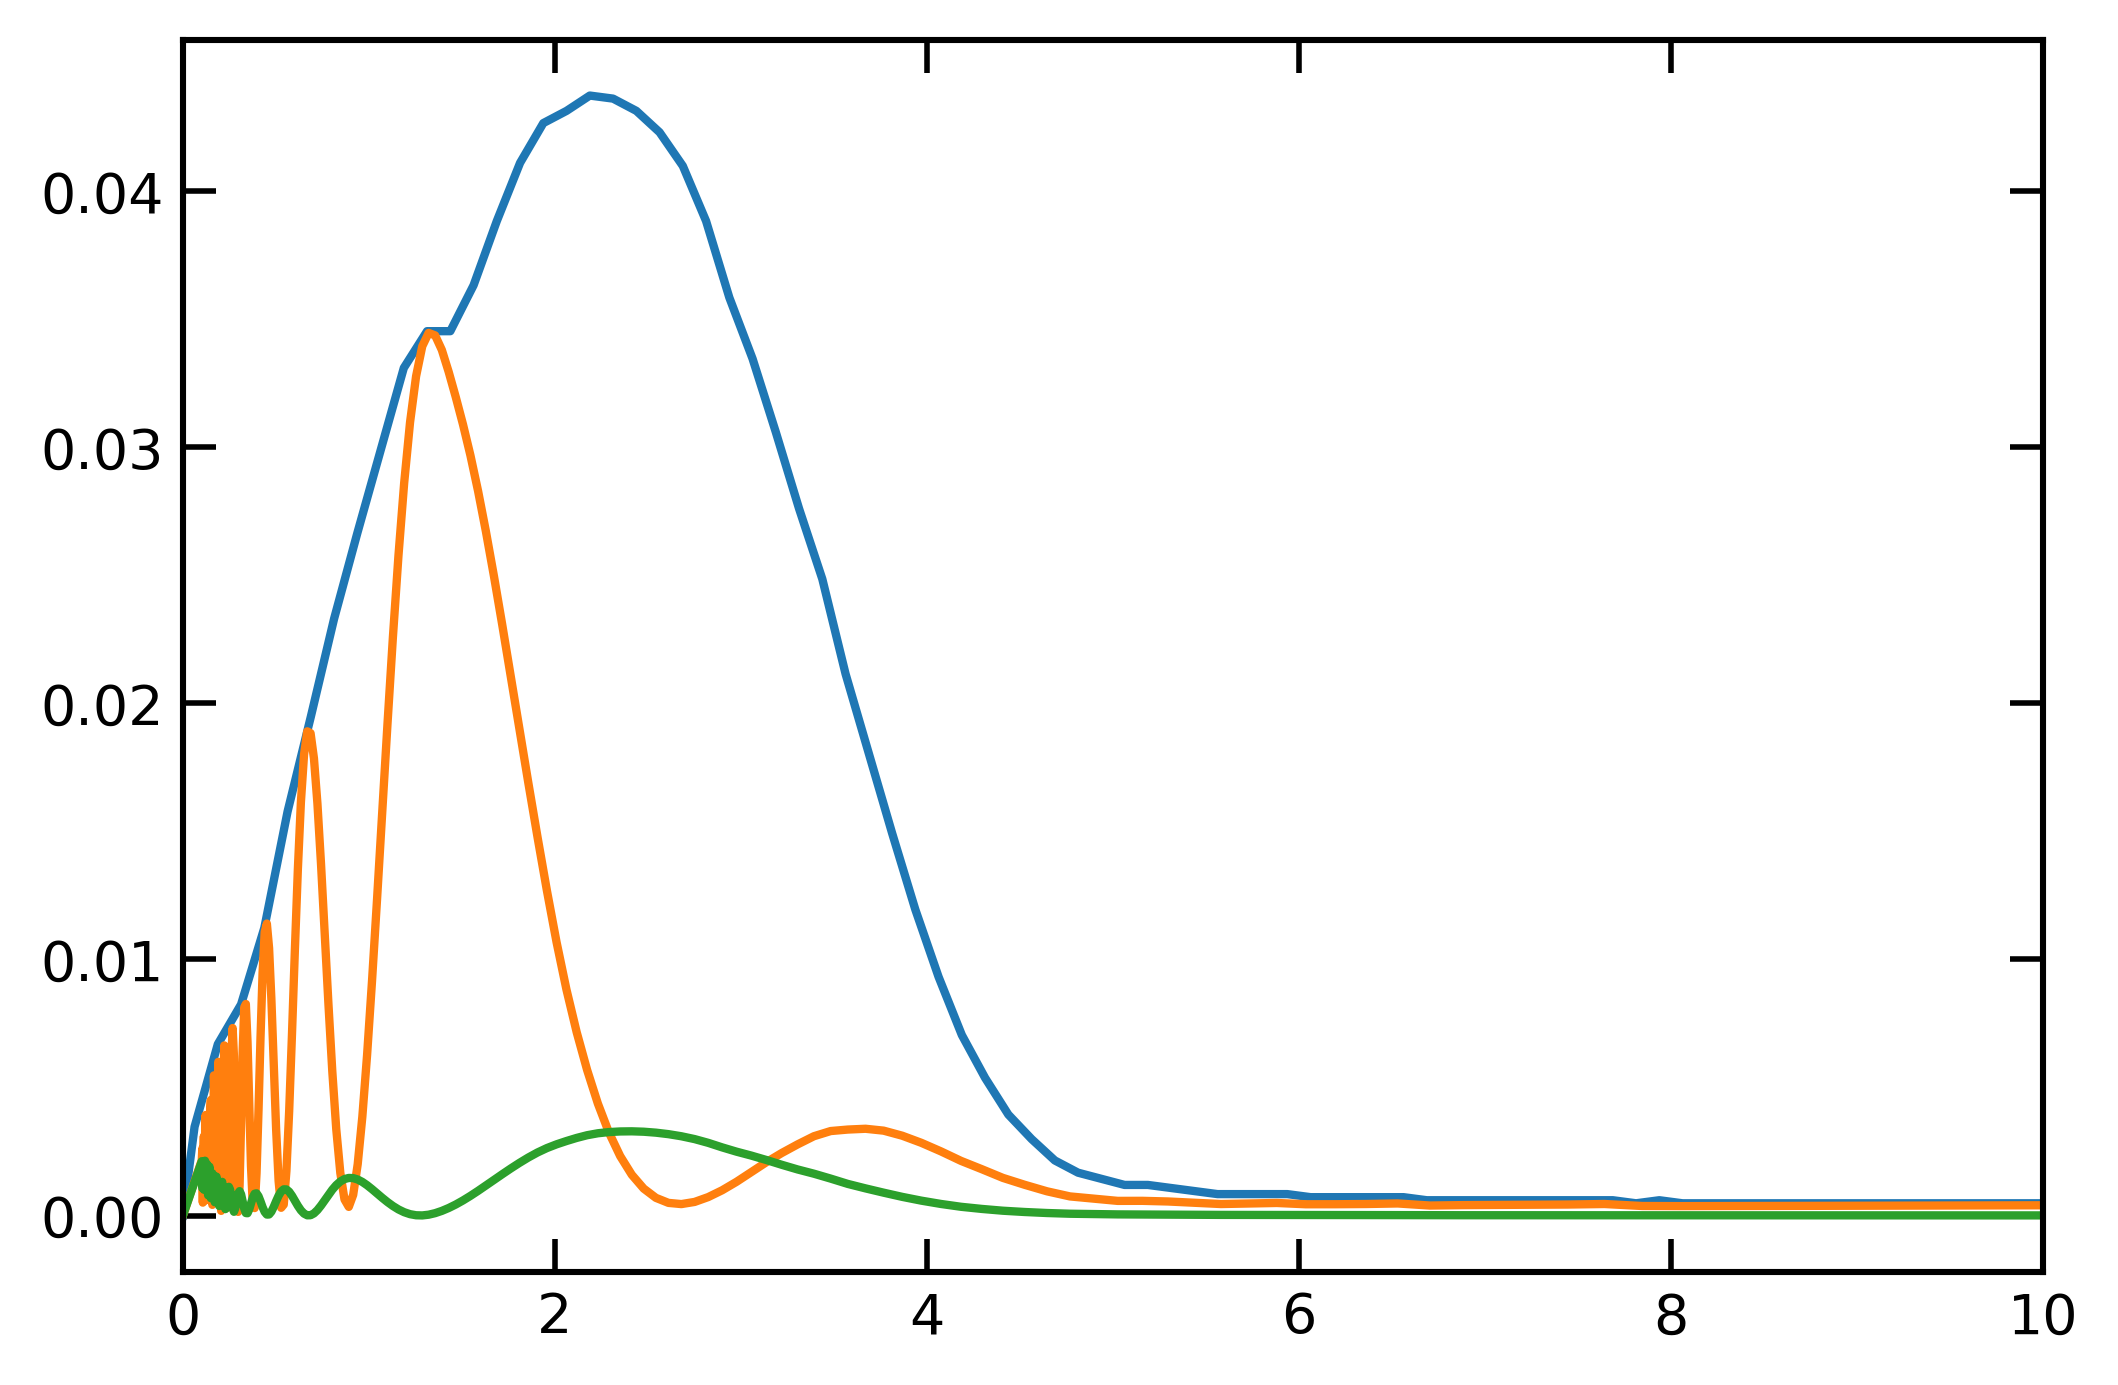

In [34]:
plt.xlim([0,10])
xpoints=[x for x in numu_flux_dist.get_bin_centers()]
xpoints.insert(0,0)
ypoints=[x for x in numu_flux_dist.get_flux_shape_rate()]
ypoints.insert(0,0)
plt.plot(xpoints,ypoints)
logpoints.insert(0,0)
numu_flux_dist_disp.insert(0,0)
numu_flux_dist_app.insert(0,0)
plt.plot(logpoints,numu_flux_dist_disp)
plt.plot(logpoints,numu_flux_dist_app)
plt.show()

In [8]:
pps.load_text("""
double enu_GeV(HepMC3::GenEvent const &ev){
  auto bpart = ps::sel::Beam(ev,14);
  if(!bpart) {
      return ps::kMissingDatum<int>;
  }
  return bpart->momentum().e() * 1E-3;
}

int subsample(HepMC3::GenEvent const &ev){
  auto procid = NuHepMC::ER3::ReadProcessID(ev);

  auto bpart = ps::sel::Beam(ev,14);
  if(!bpart) {
      return 0;
  }

  auto cclep = ps::sel::PrimaryCCLepForNu(ev,bpart);
  if(!cclep){
    return 1;
  }

  if( (200 <= procid) && (procid < 400) ){ //qe+2p2h
    return 2;
  } else if ( (400 <= procid) && (procid < 500) ){ //res
    return 3;
  } else if ( (500 <= procid) && (procid < 700) ){ //sis+dis
    return 4;
  }
  return 0;
}
""")

True

In [9]:
files_nuwro_low = ["/root/scratch/IOPPaper/ngen_low_%s/eventsout.low.%s.root" % (x,x) for x in range(10) ]
files_nuwro_high = ["/root/scratch/IOPPaper/ngen_high_%s/eventsout.high.%s.root" % (x,x) for x in range(10) ]

files_neut_low = ["/root/scratch/IOPPaper/neutgen_low_%s/neutvect.low.%s.root" % (x,x) for x in range(10) ]
files_neut_high = ["/root/scratch/IOPPaper/neutgen_high_%s/neutvect.high.%s.root" % (x,x) for x in range(10) ]

evs_neut_low = pn.EventSource({"filepaths":files_neut_low})
if not evs_neut_low:
    print("Error: failed to open input file")

evs_neut_high = pn.EventSource({"filepaths":files_neut_high})
if not evs_neut_high:
    print("Error: failed to open input file")

evs_nuwro_low = pn.EventSource({"filepaths":files_nuwro_low})
if not evs_nuwro_low:
    print("Error: failed to open input file")

evs_nuwro_high = pn.EventSource({"filepaths":files_nuwro_high})
if not evs_nuwro_high:
    print("Error: failed to open input file")

In [10]:
fg_neut_low = pn.EventFrameGen(evs_neut_low,int(25E4)).limit(1E7) \
    .add_column("enu_GeV", pps.project.get("enu_GeV")) \
    .add_column("sample", pps.select.get("subsample"))

fg_neut_high = pn.EventFrameGen(evs_neut_high,int(25E4)).limit(1E7) \
    .add_column("enu_GeV", pps.project.get("enu_GeV")) \
    .add_column("sample", pps.select.get("subsample"))

fg_nuwro_low = pn.EventFrameGen(evs_nuwro_low,int(25E4)).limit(1E7) \
    .add_column("enu_GeV", pps.project.get("enu_GeV")) \
    .add_column("sample", pps.select.get("subsample"))

fg_nuwro_high = pn.EventFrameGen(evs_nuwro_high,int(25E4)).limit(1E7) \
    .add_column("enu_GeV", pps.project.get("enu_GeV")) \
    .add_column("sample", pps.select.get("subsample"))

In [11]:
chunk_neut_low = fg_neut_low.firstArrow(int(1E6))
chunk_neut_high = fg_neut_high.firstArrow(int(1E6))

chunk_nuwro_low = fg_nuwro_low.firstArrow(int(1E6))
chunk_nuwro_high = fg_nuwro_high.firstArrow(int(1E6))

In [12]:
import copy
import numpy as np

def getxsec_GeV(enu_GeV_hist, flux, per_enu=False):
    flux.set_units("GEV")

    flux_bin_centers = flux.get_bin_centers()
    flux_shape_interp = scipy.interpolate.CubicSpline(flux.get_bin_centers(), flux.get_flux_shape_density())

    sumw = enu_GeV_hist.sumweights.copy()
    var = enu_GeV_hist.variances.copy()
    num_rows, num_cols = sumw.shape

    for ri,b in enumerate(enu_GeV_hist.binning.bins):
        enu_ext = b[0]
        
        #only cover bins in in the input flux
        if( (enu_ext.high < flux.bin_edges[0]) or (flux.bin_edges[-1] < enu_ext.low) ):
            continue

        frac_of_flux_averaged_nu = ((flux_shape_interp(enu_ext.low) + flux_shape_interp(enu_ext.high))/2.0) * (enu_ext.high - enu_ext.low)

        scale_factor = 1.0/frac_of_flux_averaged_nu
        if(per_enu):
            scale_factor /= ((enu_ext.low + enu_ext.high)/2.0)
        
        for ci in range(num_cols):
            sumw[ri,ci] *= scale_factor
            var[ri,ci] *= scale_factor*scale_factor

    xsec_hist = copy.copy(enu_GeV_hist)
    xsec_hist.sumweights = sumw
    xsec_hist.variances = var

    return xsec_hist

In [13]:
gri_low = evs_neut_low.run_info()
numu_flux_dist_low = nhm.ReaderUtils.GC7.read_energy_distribution(gri_low,14)

gri_high = evs_neut_high.run_info()
numu_flux_dist_high = nhm.ReaderUtils.GC7.read_energy_distribution(gri_high,14)

In [14]:
def make_xsec_hist(chunk_low, chunk_high, ni_low, ni_high):
    enu_hist_low = pn.HistFrame(pn.Binning.log10_space(0.1,10,25))
    enu_hist_low.add_column("NC")
    enu_hist_low.add_column("QE+MEC")
    enu_hist_low.add_column("RES")
    enu_hist_low.add_column("DIS")
    
    enu_hist_high = copy.copy(enu_hist_low)
    
    enu_hist_low.fill_columns_from_RecordBatch(chunk_low, ["enu_GeV"], "sample")
    enu_hist_high.fill_columns_from_RecordBatch(chunk_high, ["enu_GeV"], "sample")

    # fatx is in pb/A, 1E2/40 takes it to 10^-38 cm^2/N
    lowsf = (ni_low.fatx/ni_low.sumweights) * (1.0E2/40.0)
    highsf = (ni_high.fatx/ni_high.sumweights) * (1.0E2/40.0)

    xsec_low = getxsec_GeV(enu_hist_low, numu_flux_dist_low, True)
    xsec_high = getxsec_GeV(enu_hist_high, numu_flux_dist_high, True)
    
    xsec_low.sumweights *= lowsf
    xsec_high.sumweights *= highsf
    xsec_low.variances *= lowsf*lowsf
    xsec_high.variances *= highsf*highsf
    
    xsec = copy.copy(xsec_low)
    xsec.sumweights += xsec_high.sumweights
    xsec.variances += xsec_high.variances
    
    return xsec

In [15]:
xsec_neut = make_xsec_hist(chunk_neut_low,chunk_neut_high,fg_neut_low.norm_info(),fg_neut_high.norm_info())
xsec_nuwro = make_xsec_hist(chunk_nuwro_low,chunk_nuwro_high,fg_nuwro_low.norm_info(),fg_nuwro_high.norm_info())

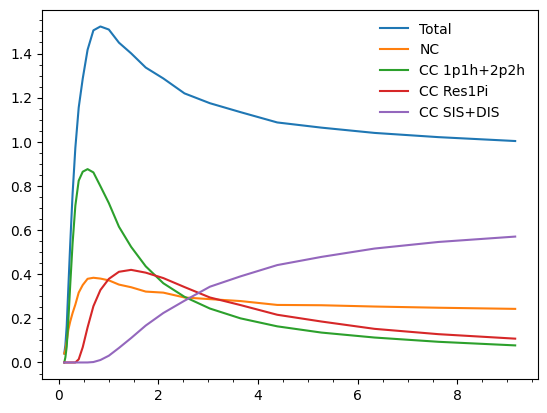

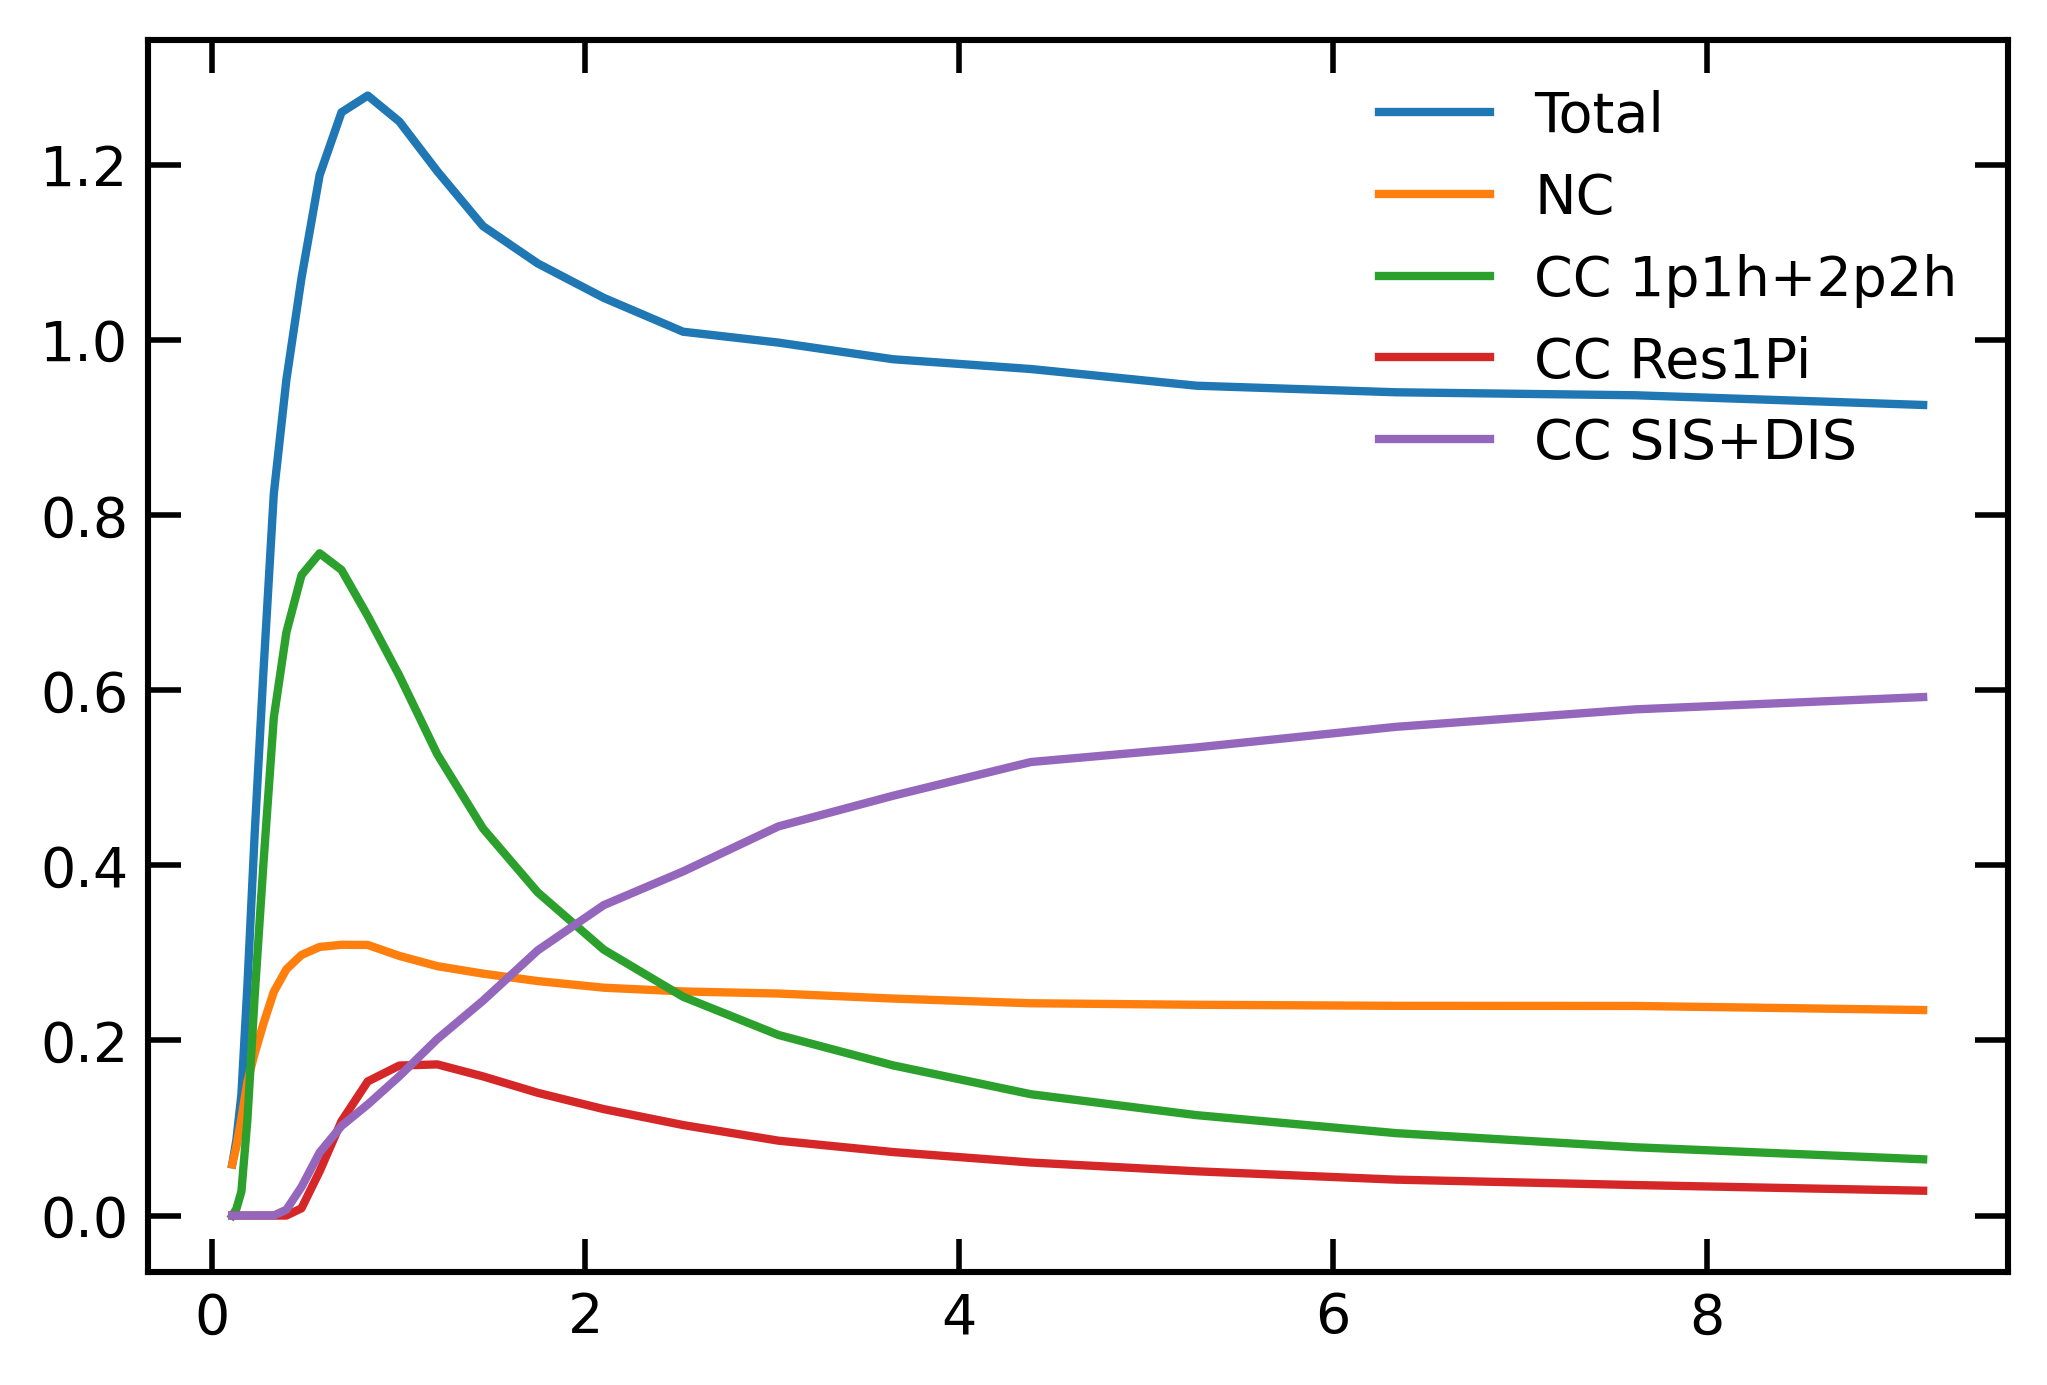

In [16]:
pn.cern([6,4])

xsec_neut.mpl().plot_all(labels=["Total","NC","CC 1p1h+2p2h", "CC Res1Pi", "CC SIS+DIS"])
plt.legend()
plt.show()

xsec_nuwro.mpl().plot_all(labels=["Total","NC","CC 1p1h+2p2h", "CC Res1Pi", "CC SIS+DIS"])
plt.legend()
plt.show()

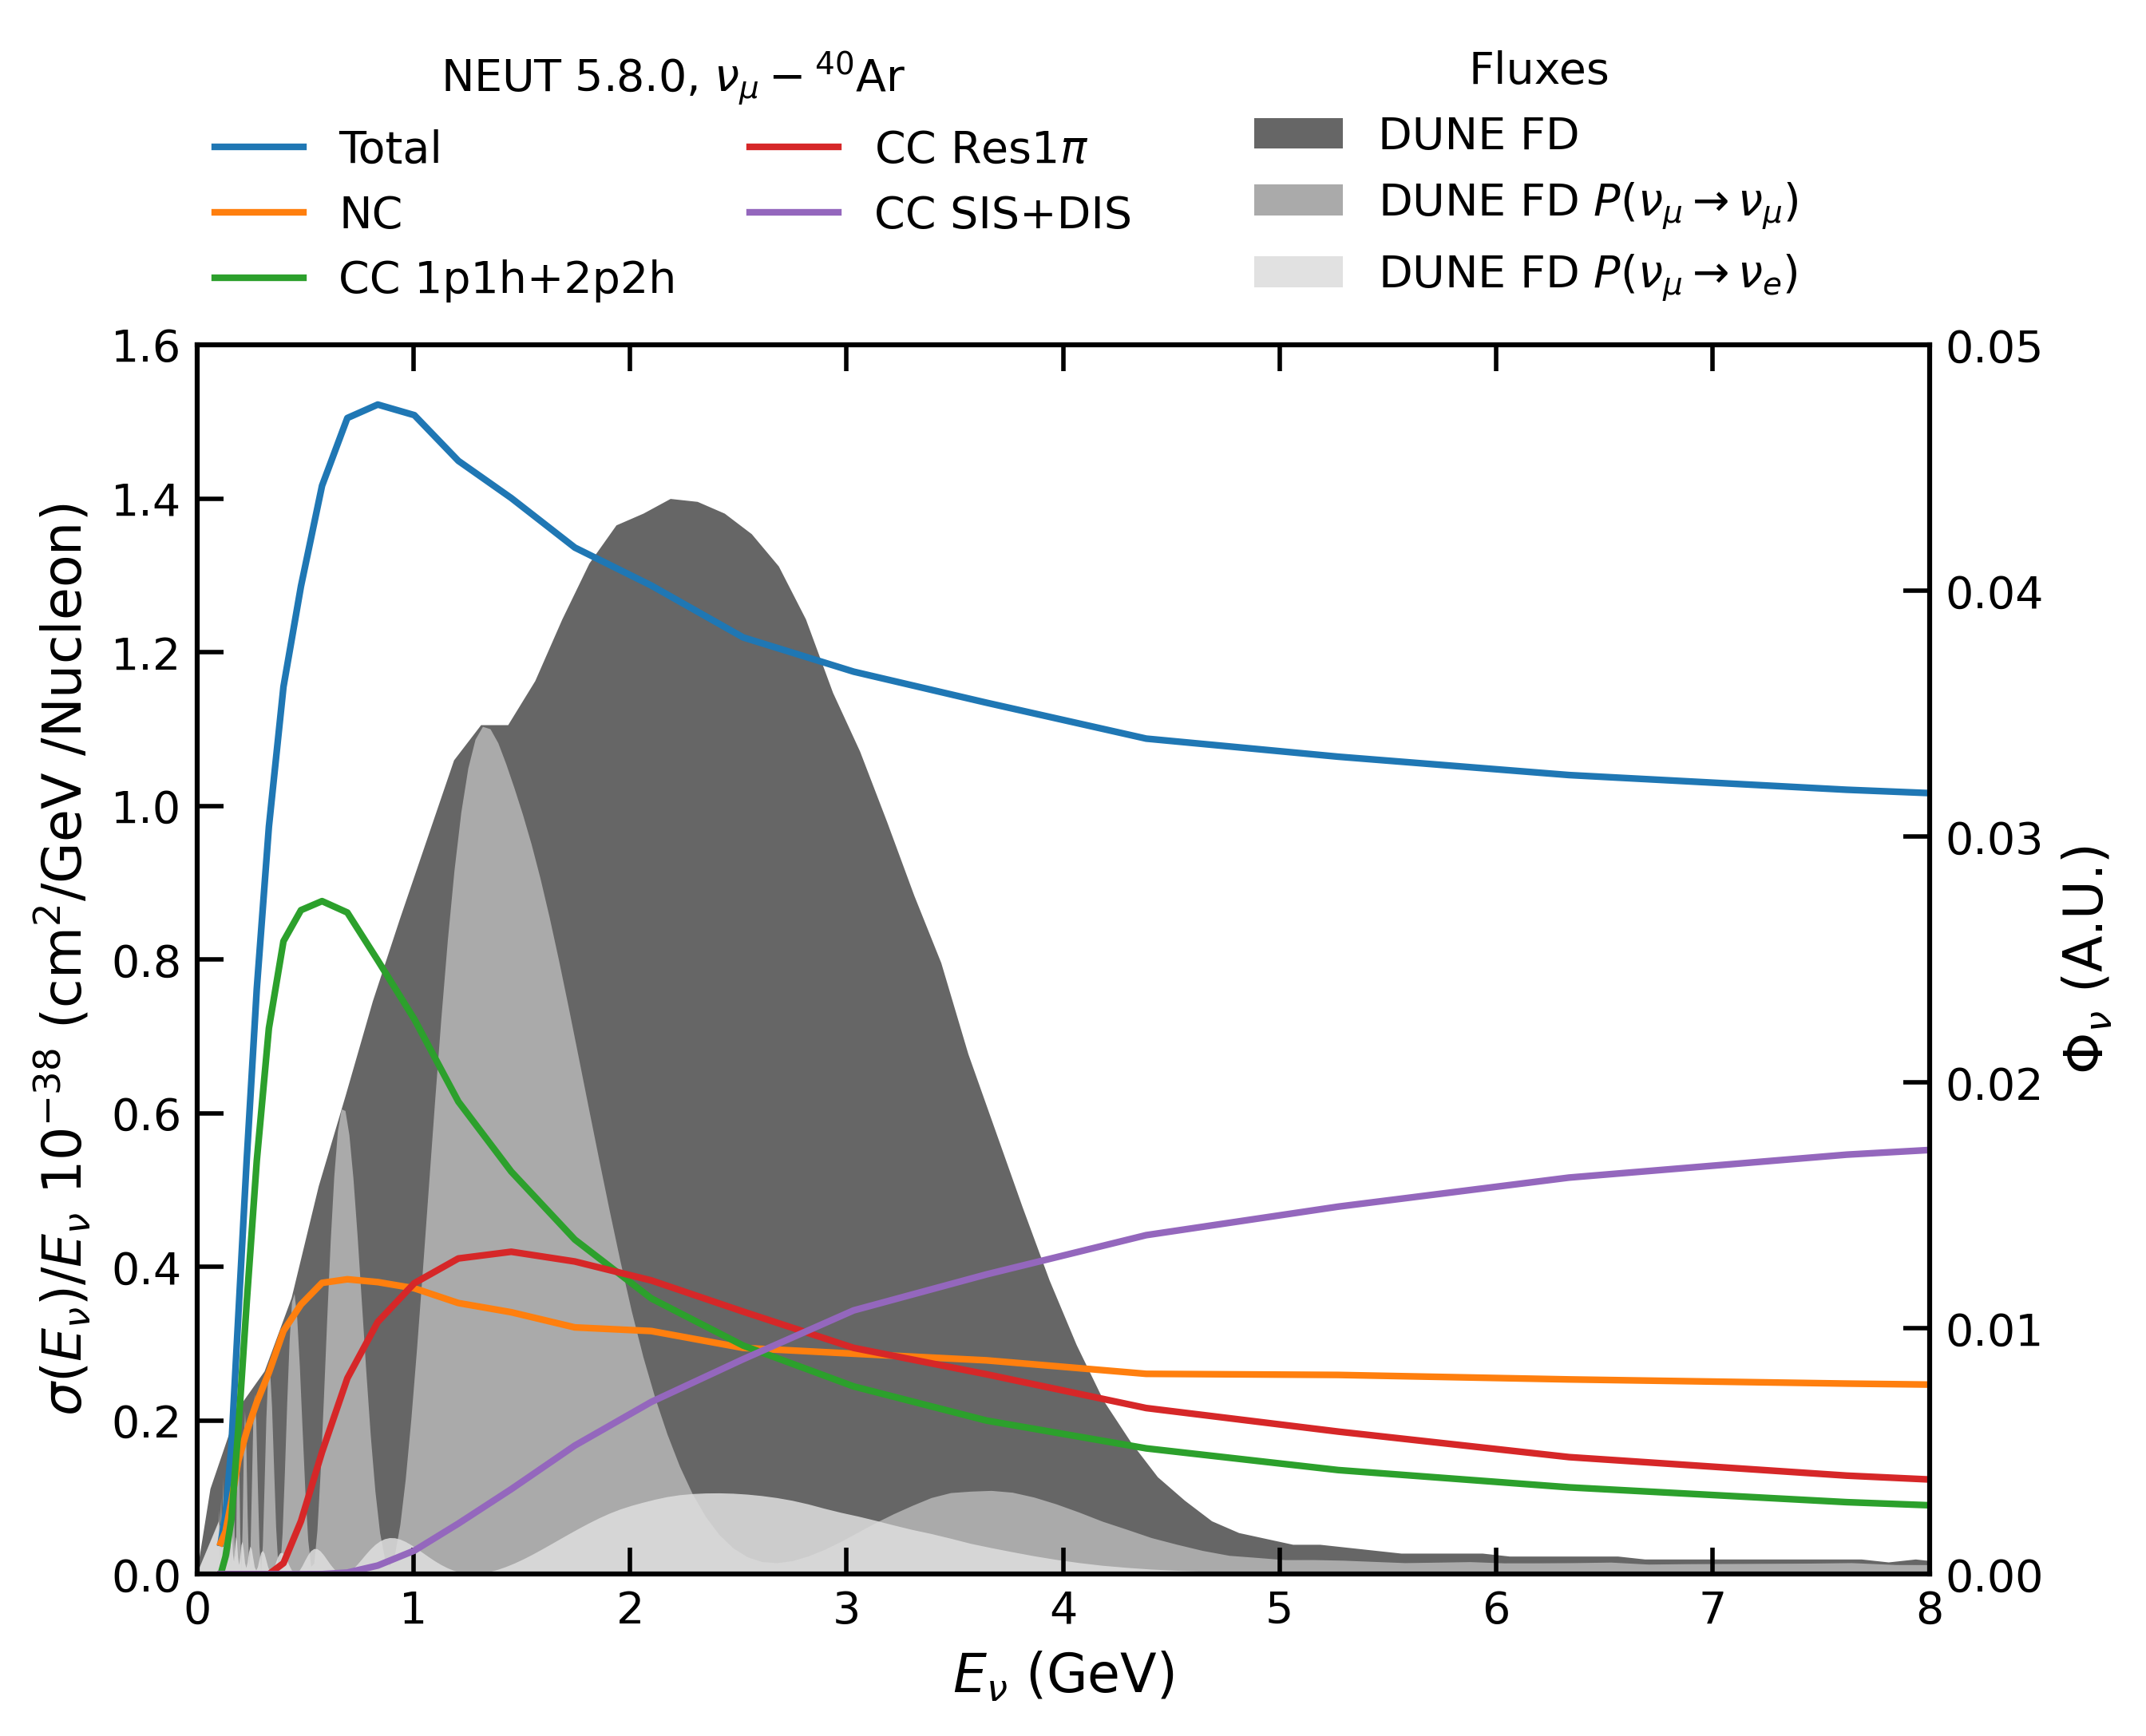

In [109]:
fig = plt.figure(figsize=[7,5])
ax1 = fig.add_subplot(111)

ax1.set_xlim([0,10])
xpoints=[x for x in numu_flux_dist.get_bin_centers()]
xpoints.insert(0,0)
ypoints=[x for x in numu_flux_dist.get_flux_shape_rate()]
ypoints.insert(0,0)
ax1.fill(xpoints,ypoints,facecolor='#666', label="DUNE FD")
logpoints.insert(0,0)
numu_flux_dist_disp.insert(0,0)
numu_flux_dist_app.insert(0,0)
ax1.fill(logpoints,numu_flux_dist_disp,facecolor='#AAA', label=r"DUNE FD $P(\nu_{\mu}\rightarrow\nu_{\mu})$")
ax1.fill(logpoints,numu_flux_dist_app,facecolor='#DDDD', label=r"DUNE FD $P(\nu_{\mu}\rightarrow\nu_{e})$")
ax1.legend(bbox_to_anchor=(0.6, 1.02, 0.35, .102), loc='lower left',
                      ncols=1, mode="expand", borderaxespad=0.,
          title="Fluxes")
ax1.set_ylabel(r"$\Phi_{\nu}$ (A.U.)")

ax2 = ax1.twinx()

ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")
ax1.set_ylim([0,0.05])

ax2.yaxis.tick_left()
ax2.yaxis.set_label_position("left")
ax2.set_ylim([0,1.6])
ax2.set_xlim([0,8])

xsec_neut.mpl().plot_all(labels=["Total","NC","CC 1p1h+2p2h", "CC Res1$\pi$", "CC SIS+DIS"], plot_axis=ax2)
ax2.legend(bbox_to_anchor=(0., 1.02, 0.55, .102), loc='lower left',
                      ncols=2, mode="expand", borderaxespad=0.,
          title=r"NEUT 5.8.0, $\nu_{\mu}-{}^{40}\text{Ar}$")
ax2.set_ylabel(r"$\sigma(E_{\nu})/E_{\nu}\ 10^{-38}\ (\text{cm}^{2} /\text{GeV}\ /\text{Nucleon})$")

ax1.set_xlabel(r"$E_{\nu}$ (GeV)")

fig.show()
fig.savefig("osc.png", bbox_inches='tight')